In [1]:
import sys
sys.path.insert(0, '..')

from eda_import import *

In [2]:
import matplotlib.patches as patches

In [3]:
print(datetime.datetime.today().date())

2018-07-04


In [4]:
TOTAL_NUM_CALLS = 67544140

In [5]:
%time adf = pd.read_pickle('../__results/all_cba.KLEAT.on-target-cleaned-hexamer-researched.pkl')

CPU times: user 1.2 s, sys: 325 ms, total: 1.52 s
Wall time: 1.53 s


# map clv to a closest clustered annotated CS

In [6]:
df_clv_sc = pd.read_csv('../__results/annotated-clv-sc-mapping.csv', keep_default_na=False)

In [7]:
df_clv_sc.query('transcript_id == "ENST00000544168"')

,gene_name,transcript_id,seqname,source,sc,clv,strand,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF,utr_beg,cluster_idx,aclv,mclv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,sdist_aclv2ahex
4,AKT1,ENST00000544168,14,protein_coding,105236678,105236492,-,ensembl_havana,ensembl_havana,False,False,105236677,4,105236492,105236491,NA,-1,-1,-1,


In [8]:
# first create a dict of gene-to-clvs map
# ONLY use the mclv value in annotation, its clv is mainly for debugging purpose
ANNOT_GENE2CLV_DD = df_clv_sc.groupby(['gene_name']).apply(lambda g: g.aclv.unique())
def map_kclv2aclv(row):
    """map KLEAT predicted clv to a closest annotated clv"""
    gene = row.gene_name
    kclv = row['clv']
    poss_aclvs = ANNOT_GENE2CLV_DD[gene]
    return poss_aclvs[np.argmin(np.abs(poss_aclvs - kclv))]

In [9]:
_df = adf[['gene_name', 'clv']].drop_duplicates()

In [10]:
assert _df.shape[0] == 459113

In [11]:
%time _df['aclv'] = _df.apply(map_kclv2aclv, axis=1)

CPU times: user 16.6 s, sys: 97.1 ms, total: 16.7 s
Wall time: 16.5 s


In [12]:
%time bdf = adf.merge(_df, on=['gene_name', 'clv'], how='left')

CPU times: user 2.65 s, sys: 262 ms, total: 2.91 s
Wall time: 2.91 s


In [13]:
assert bdf.shape[0] == 11489199
assert bdf.shape[0] == adf.shape[0]

In [14]:
bdf.head(1)

,gene_name,strand,seqname,clv,length_of_tail_in_contig,number_of_bridge_reads,max_bridge_read_tail_length,analysis_id,clv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,aclv
0,RTCA,+,chr1,100732395,0,0,0,1d811d54-caa1-41f3-bfc2-400eebdd97ef,100732394,NA,-1,-1,-1,100732485


In [15]:
# NDA: could be a misnomer, supposed to be unsigned-distance to annotated clv
bdf['signed_NDA'] = bdf['clv'] - bdf['aclv']
bdf['NDA'] = bdf['signed_NDA'].abs()

# Prepare filtering

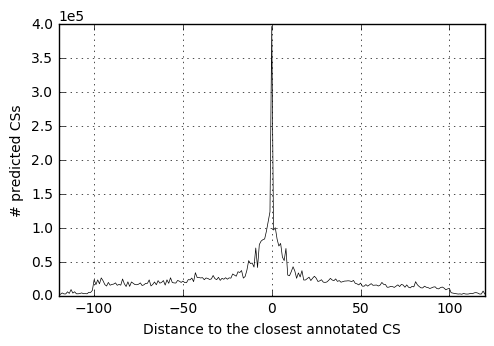

In [16]:
# ax = bdf_flag1['signed_NDA'].value_counts().sort_index().plot(lw=0.5, color='black', linestyle='--', label='flag = 1')
# bdf_flag2['signed_NDA'].value_counts().sort_index().plot(ax=ax, lw=0.5, color='black', linestyle='-.', label='flag = 2')
# bdf['signed_NDA'].value_counts().sort_index().plot(ax=ax, lw=0.5, color='black', linestyle='-', label='both')

fig = plt.figure(figsize=(5.5, 3.5))
ax = fig.add_subplot(111)
bdf['signed_NDA'].value_counts().sort_index().plot(ax=ax, lw=0.5, color='black', linestyle='-')
ax.set_xlim(-120, 120)
# ax.set_ylim(0, 7e5)
ax.set_ylabel('# predicted CSs')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 2))
ax.grid()
ax.set_xlabel('Distance to the closest annotated CS')
ax.legend().remove()
# plt.savefig('./results/figs/distr-of-NDA-before-2nd-filtering.jpg', dpi=350)

In [17]:
# hc_b2f: hexamer count before 2nd filtering
hc_b2f_with_NA_counts = bdf.hexamer.value_counts().to_frame('After initial filtering')
hc_b2f_with_NA = (bdf.hexamer.value_counts() / bdf.hexamer.value_counts().sum()).to_frame('After initial filtering')

# Start filtering

```
awk '($11>=4 || $13>=2 || $14>=4) && ($20!="-")'

length_of_tail_in_contig MINIMUM OF 4 OR
number_of_bridge_reads MINIMUM OF 2 OR
max_bridge_read_tail_length MINIMUM OF 4 (i.e. OK if there is just one bridge read, but it must have at least 4 A's)

ONE of the above AND there must be a hexamer motif (doesn't matter how strong it is)
```

In [18]:
cdf = bdf[
    (
        bdf.NDA <= 25
    ) 
    | 
    (    
        (
            (bdf.length_of_tail_in_contig >= 4) | 
            (bdf.number_of_bridge_reads >= 2) |
            (bdf.max_bridge_read_tail_length >= 4)
        )
        & 
        (
            bdf.hexamer.isin(["AATAAA", "ATTAAA"])
        )
    )
].copy()

In [19]:
assert cdf.shape[0] == 3420253

In [20]:
print('{0:.3%} data remained'.format(cdf.shape[0] / TOTAL_NUM_CALLS))

5.064% data remained


In [21]:
hc_a2f_with_NA_counts = cdf.hexamer.value_counts().to_frame('After second filtering')
hc_a2f_with_NA = (cdf.hexamer.value_counts() / cdf.hexamer.value_counts().sum()).to_frame('After second filtering')

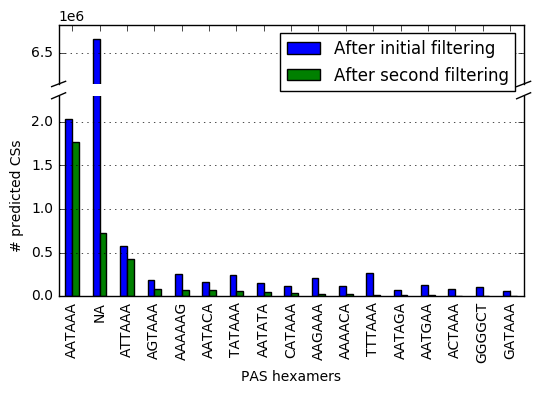

In [22]:
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

fig = plt.figure(figsize=(6, 3.5))
nrows = 12
ratio = 1 / (1 + 3) # meaning the first subplot is 1/3 height of the second one
gs = gridspec.GridSpec(nrows, 1, hspace=1)
ax1 = fig.add_subplot(gs[:int(nrows * ratio), :])
ax2 = fig.add_subplot(gs[int(nrows * ratio):,:])

merged = hc_b2f_with_NA_counts\
    .merge(hc_a2f_with_NA_counts, left_index=True, right_index=True, how='outer')\
    .fillna(0).sort_values('After second filtering', ascending=False)

merged.plot.bar(ax=ax1)
merged.plot.bar(ax=ax2)
    
ylim_max = 2.3e6
ax2.set_ylim(0, ylim_max)  # most of the data
ax1.set_yticks(np.arange(6e6, 7.5e6, 5e5))
ax1.set_ylim(6.1e6, 6.1e6 +  ylim_max * ratio / (1 - ratio))  # outliers only

ax2.legend().set_visible(False)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.set_xlabel('')
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.set_xlabel('PAS hexamers')
ax2.set_ylabel('# predicted CSs')
ax1.yaxis.grid(zorder=0)
ax2.yaxis.grid(zorder=0)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(flip(handles, 2), flip(labels, 2), loc='upper right', ncol=2)

scaler = 1 / ratio - 1
ax1.plot((-d, +d), (-d * scaler, d * scaler), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d * scaler, d * scaler), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 2))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 2))
# http://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
ax2.yaxis.offsetText.set_visible(False)

# plt.savefig('./figs/hexamer_counts.jpg', dpi=350, bbox_inches='tight')

In [23]:
hc_a2f_with_NA.T

,AATAAA,NA,ATTAAA,AGTAAA,AAAAAG,AATACA,TATAAA,AATATA,CATAAA,AAGAAA,AAAACA,TTTAAA,AATAGA,AATGAA,ACTAAA,GGGGCT,GATAAA
After second filtering,0.517487,0.212599,0.12615,0.023182,0.022528,0.020454,0.019071,0.013456,0.009491,0.008223,0.006802,0.005811,0.005694,0.005081,0.001703,0.001528,0.00074


# Plot the distributions again

In [24]:
cdf.query('NDA > 10').shape[0] / cdf.shape[0]

0.4549102069349841

In [25]:
cdf.query('NDA <= 15').shape[0] / cdf.shape[0]

0.6573677444329411

In [26]:
cdf.query('NDA <= 10').shape[0] / cdf.shape[0]

0.5450897930650159

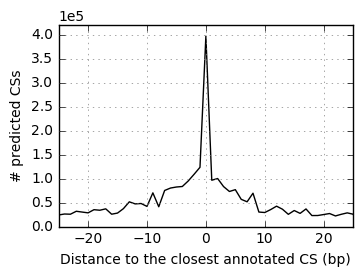

In [27]:
fig = plt.figure(figsize=(3.8, 2.6))
ax = fig.add_subplot(111)

ax = cdf['signed_NDA'].value_counts().sort_index().plot(lw=1, color='black', label='distance to an annotated CS')
ax.set_xlim(-25, 25)
ax.set_ylim(0, 4.2e5)
# ax.set_yscale('log')
ax.grid(lw=0.5, color='gray')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 2))
ax.set_xlabel('Distance to the closest annotated CS (bp)')
ax.set_ylabel('# predicted CSs')

# ax.legend()
plt.savefig('../__results/figs/distr-of-non-signed-distance-to-annotated-clv.jpg', bbox_inches='tight', dpi=500)

#### distr. of distance to hexamer

In [28]:
ddf = cdf.query('hexamer_id != -1').copy()
ddf['sdist_clv2hex'] = ddf['clv'] - ddf['hexamer_loc']
ddf['dist_clv2hex'] = ddf.sdist_clv2hex.abs()
ddf['sdist_aclv2hex'] = ddf['aclv'] - ddf['hexamer_loc']
ddf['dist_aclv2hex'] = ddf.sdist_clv2hex.abs()

In [29]:
ddf.shape[0] / cdf.shape[0]

0.7874005227098697

So 79% of the CSs have an associated hexamer

In [30]:
ddf.head(1)

,gene_name,strand,seqname,clv,length_of_tail_in_contig,number_of_bridge_reads,max_bridge_read_tail_length,analysis_id,clv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,aclv,signed_NDA,NDA,sdist_clv2hex,dist_clv2hex,sdist_aclv2hex,dist_aclv2hex
1,RTCA,+,chr1,100732476,0,0,0,1d811d54-caa1-41f3-bfc2-400eebdd97ef,100732475,TTTAAA,14,100732435,100732436,100732485,-9,9,40,40,49,40


Tried to extract annotated hexamer loc

Settle: using the distance between aclv and hexamer found based on annotated clv (before clustering) is too complicated, as the region changes before and after clustering, so just ignore it and use the distance between KLEAT clv and hexamer found based on it instead.

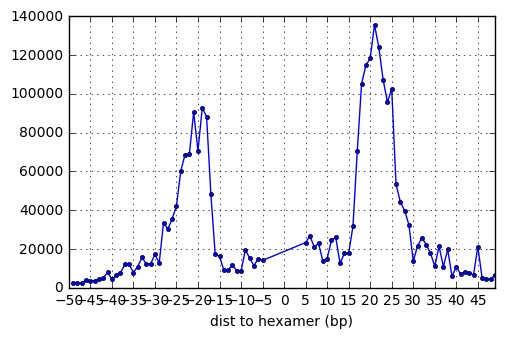

In [31]:
# this is a crude version: this plot confirms the minimum dist is 5 bp 
fig = plt.figure(figsize=(5.5, 3.5))
ax = ddf['sdist_clv2hex'].value_counts().sort_index().plot(marker='o', markersize=3)
ax.grid()
_ = ax.set_xticks(np.arange(-50, 50, 5))
ax.set_xlabel('dist to hexamer (bp)')

In [32]:
ddf.query('strand == "-"').sdist_clv2hex.value_counts().head()

-19    92845
-21    90525
-18    88152
-20    70513
-22    68842
Name: sdist_clv2hex, dtype: int64

In [33]:
ddf.query('strand == "+"').sdist_clv2hex.value_counts().head()

21    135649
22    123927
20    118226
19    114710
23    107265
Name: sdist_clv2hex, dtype: int64

So the most probable dist is around 21 bp for both strands

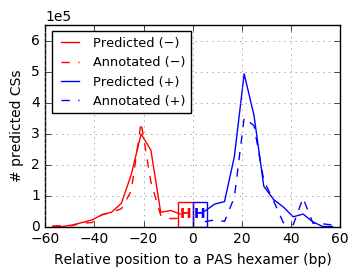

In [39]:
fig = plt.figure(figsize=(3.8, 2.6))
ax = fig.add_subplot(111)
# a step of 2 makes it more smooth

for (strand, bins, color) in reversed(list(zip(
    ['+', '−'], 
    [np.arange(3, 61, 4), -np.arange(3, 61, 4)[::-1]],
    ['blue', 'red']
    ))):
    for (col, label, ls) in zip(
        ['sdist_clv2hex', 'sdist_aclv2hex'], 
        ['Predicted', 'Annotated'],
        ['-', '--']):
        hist, bs = np.histogram(ddf[col].values, bins=bins)
        bs = (bs[1:] + bs[:-1]) / 2
        # ax.plot(bs, hist, color='black', marker='o', markersize=5, linestyle=ls, label=label)

        ax.plot(bs, hist, color=color,
#                 marker='o', markersize=4, 
                linestyle=ls, 
                label=label + ' ({0})'.format(strand))

min_bp = 6
hbox_height = 8e4
ax.add_patch(
    patches.Rectangle(
        (-min_bp, 0),      # (x,y)
        min_bp,            # width
        hbox_height,  # height
        color='red',
        fill=False,
    )
)
ax.text(-3, hbox_height / 2, 'H', color='red', weight='bold', ha='center', va='center')

ax.add_patch(
    patches.Rectangle(
        (0, 0),      # (x,y)
        min_bp,           # width
        hbox_height, # height
        color='blue',
        fill=False,
    )
)
ax.text(3, hbox_height / 2, 'H', color='blue', weight='bold', ha='center', va='center')


ax.legend(loc='upper left', fontsize=9.3, framealpha=1, ncol=1)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 2))
ax.set_xlabel('Relative position to a PAS hexamer (bp)')
ax.set_ylabel('# predicted CSs')
ax.set_ylim(0, 6.5e5)
_ = ax.set_xticks(np.arange(-60, 61, 20))
ax.grid(lw=0.5, color='gray')
plt.savefig('../__results/figs/distr_distance_to_hexamer.jpg', bbox_inches='tight', dpi=500)

In [36]:
%time cdf.to_pickle('../__results/all_cba.KLEAT.on-target-cleaned.filtered.pkl')

CPU times: user 1.01 s, sys: 600 ms, total: 1.61 s
Wall time: 2.91 s


In [37]:
assert cdf.shape[0] == 3420253

In [38]:
cdf.shape[0] / TOTAL_NUM_CALLS

0.05063730177036824